In [ ]:
from sklearn.datasets import load_sample_images
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
!wget https://raw.githubusercontent.com/databyhuseyn/DeepLearning/main/helper_functions.py

--2024-05-10 11:26:13--  https://raw.githubusercontent.com/databyhuseyn/DeepLearning/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-05-10 11:26:13 (107 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [ ]:
from helper_functions import plot_loss_curves

(-0.5, 639.5, 426.5, -0.5)

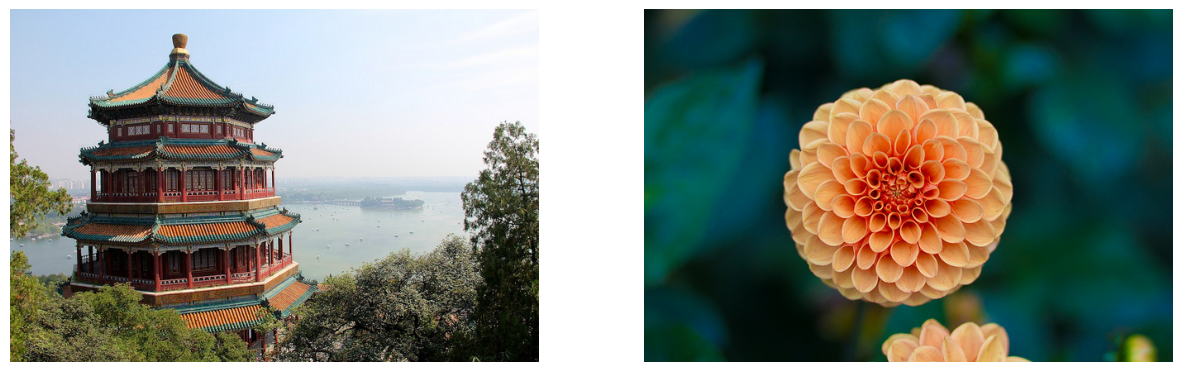

In [ ]:
images = load_sample_images()['images']
plt.figure(figsize = (15, 10))
plt.subplot(121)
plt.imshow(images[0])
plt.axis('off')
plt.subplot(122)
plt.imshow(images[1])
plt.axis('off')

(-0.5, 119.5, 69.5, -0.5)

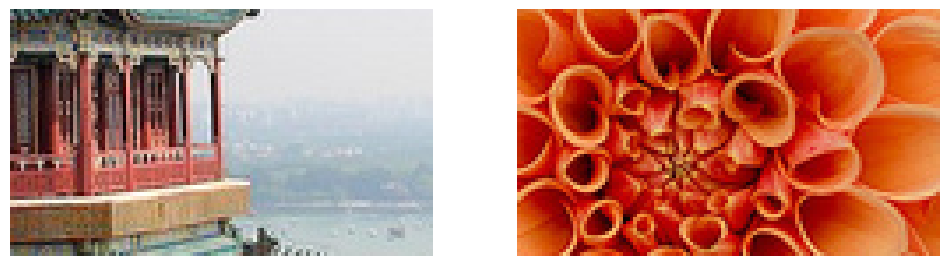

In [ ]:
images = tf.keras.layers.CenterCrop(height=70, width=120)(images)
images = tf.keras.layers.Rescaling(scale = 1/255.)(images)
plt.figure(figsize = (12, 8))
plt.subplot(121)
plt.imshow(images[0])
plt.axis('off')
plt.subplot(122)
plt.imshow(images[1])
plt.axis('off')

In [ ]:
images.shape

TensorShape([2, 70, 120, 3])

In [ ]:
tf.random.set_seed(42)
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7)
fmaps = conv_layer(images)

In [ ]:
fmaps.shape

TensorShape([2, 64, 114, 32])

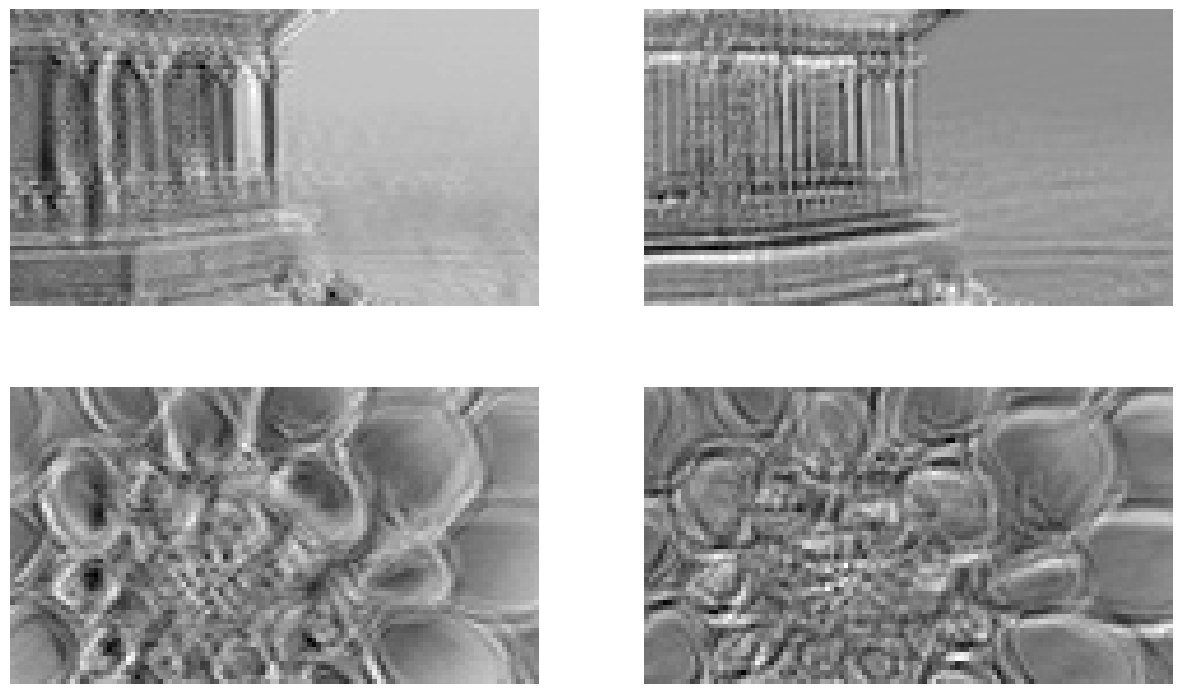

In [ ]:
plt.figure(figsize=(15, 9))
for image_idx in (0, 1):
  for fmap_idx in (0, 1):
    plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
    plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap='gray')
    plt.axis('off')

plt.show()

In [ ]:
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7,
                                    padding='same')
fmaps = conv_layer(images)

In [ ]:
fmaps.shape

TensorShape([2, 70, 120, 32])

In [ ]:
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7, padding='same',
                                    strides=2)
fmaps = conv_layer(images)
fmaps.shape

TensorShape([2, 35, 60, 32])

In [ ]:
import numpy as np

def conv_output_size(input_size, kernel_size, strides=1, padding="valid"):
    if padding=="valid":
        z = input_size - kernel_size + strides
        output_size = z // strides
        num_ignored = z % strides
        return output_size, num_ignored
    else:
        output_size = (input_size - 1) // strides + 1
        num_padded = (output_size - 1) * strides + kernel_size - input_size
        return output_size, num_padded

conv_output_size(np.array([70, 120]), kernel_size=10, strides=4,
                 padding="same")

(array([18, 30]), array([8, 6]))

In [ ]:
kernels, biases = conv_layer.get_weights()
kernels.shape

(7, 7, 3, 32)

In [ ]:
tf.random.set_seed(42)
filters = tf.random.normal([7, 7, 3, 2])
biases = tf.zeros([2])
fmaps = tf.nn.conv2d(images, filters, strides=1, padding='SAME') + biases

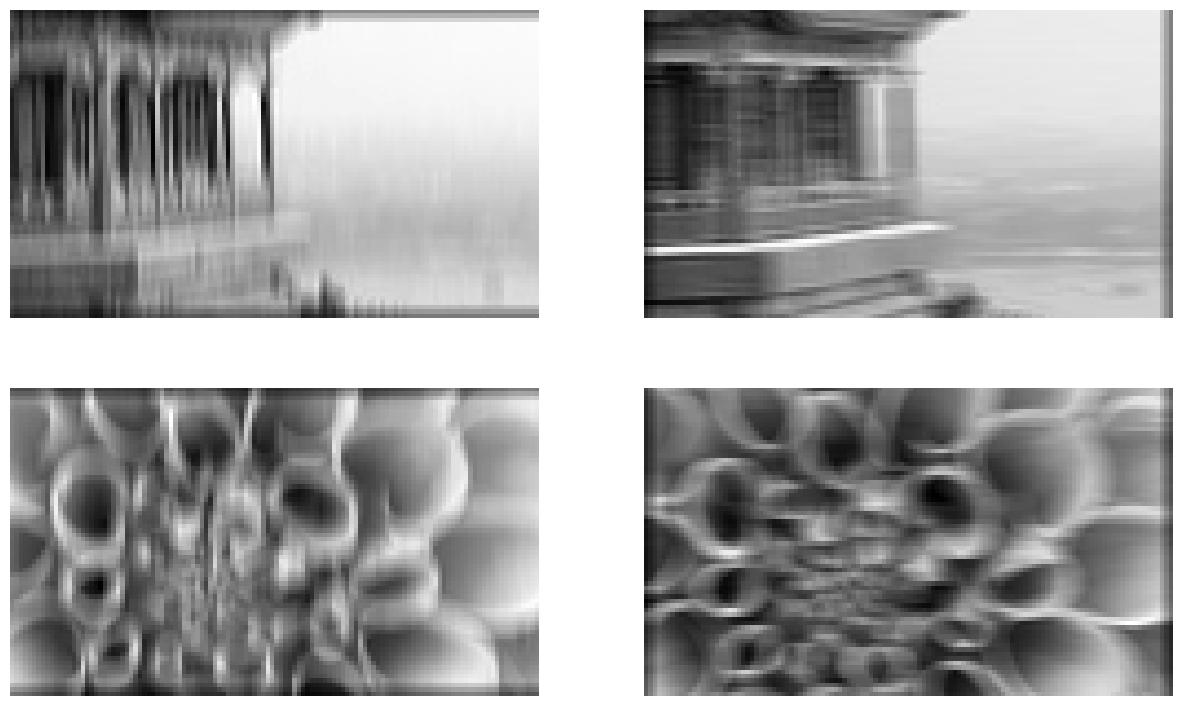

In [ ]:
plt.figure(figsize=(15, 9))
filters = np.zeros([7, 7, 3, 2])
filters[:, 3, :, 0] = 1
filters[3, :, :, 1] = 1
fmaps = tf.nn.conv2d(images, filters, strides=1, padding='SAME') + biases
for image_idx in (0, 1):
  for fmap_idx in (0, 1):
    plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
    plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap='gray')
    plt.axis('off')

plt.show()

# Implementing Pooling Layers with Keras
# Max Pooling

In [ ]:
max_pool = tf.keras.layers.MaxPool2D(pool_size=2)

In [ ]:
output = max_pool(images)

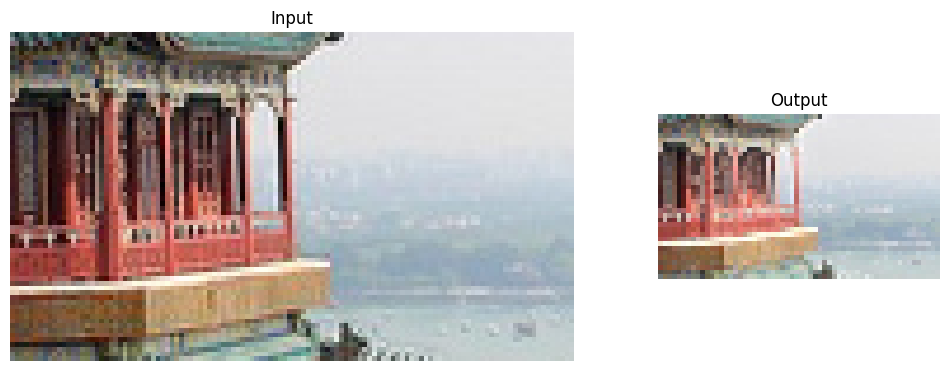

In [ ]:
import matplotlib as mpl

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1= fig.add_subplot(gs[0, 0])
ax1.set_title("Input")
ax1.imshow(images[0])
ax1.axis('off')
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output")
ax2.imshow(output[0])
ax2.axis('off')
plt.show()

In [ ]:
class DepthPool(tf.keras.layers.Layer):
  def __init__(self, pool_size=2, **kwargs):
    super().__init__(**kwargs)
    self.pool_size=pool_size

  def call(self, inputs):
    shape = tf.shape(inputs)
    groups = shape[-1] // self.pool_size
    new_shape = tf.concat([shape[:-1], [groups, self.pool_size]], axis=0)
    return tf.reduce_max(tf.reshape(inputs, new_shape), axis=-1)

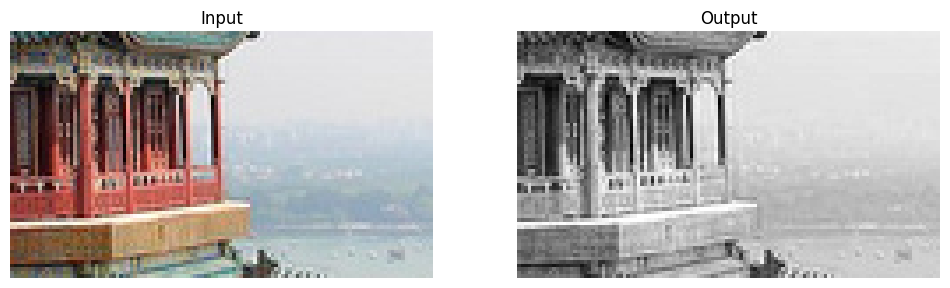

In [ ]:
depth_output = DepthPool(pool_size=3)(images)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title('Input')
plt.imshow(images[0])
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('Output')
plt.imshow(depth_output[0, ..., 0], cmap='gray')
plt.axis('off')
plt.show()

# CNN Architectures

# Tacklin Fashion MNIST With a CNN

In [ ]:
mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = mnist
X_train_full = np.expand_dims(X_train_full, axis=-1).astype(np.float32) / 255
X_test = np.expand_dims(X_test.astype(np.float32), axis=-1) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [ ]:
from functools import partial

tf.random.set_seed(42)
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding='same',
                        activation='relu', kernel_initializer='he_normal')

model = tf.keras.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='relu',
                          kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64, activation='relu',
                          kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=10, activation='softmax')
])

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam',
              metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10]
y_pred = model.predict(X_new)

Epoch 1/10
1719/1719 [==============================] - 18s 9ms/step - loss: 0.7120 - accuracy: 0.7516 - val_loss: 0.3752 - val_accuracy: 0.8686
Epoch 2/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.4151 - accuracy: 0.8599 - val_loss: 0.3089 - val_accuracy: 0.8870
Epoch 3/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.3509 - accuracy: 0.8799 - val_loss: 0.2837 - val_accuracy: 0.8972
Epoch 4/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.3138 - accuracy: 0.8936 - val_loss: 0.2614 - val_accuracy: 0.9034
Epoch 5/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.2910 - accuracy: 0.9009 - val_loss: 0.2640 - val_accuracy: 0.9028
Epoch 6/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.2695 - accuracy: 0.9075 - val_loss: 0.2519 - val_accuracy: 0.9058
Epoch 7/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.2495 - accuracy: 0.9142 - val_loss: 0.2625 - val_ac

# Implementing a ResNet-34 CNN Using Keras

In [ ]:
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding='same', kernel_initializer='he_normal',
                        use_bias=False)

class ResidualUnit(tf.keras.layers.Layer):
  def __init__(self, filters, strides=1, activation='relu', **kwargs):
    super().__init__(**kwargs)
    self.activation = tf.keras.activations.get(activation)
    self.main_layers = [
        DefaultConv2D(filters, strides=strides),
        tf.keras.layers.BatchNormalization(),
        self.activation,
        DefaultConv2D(filters),
        tf.keras.layers.BatchNormalization()
    ]
    self.skip_layers = []
    if strides > 1:
      self.skip_layers = [
          DefaultConv2D(filters, kernel_size=1, strides=strides),
          tf.keras.layers.BatchNormalization()
      ]

  def call(self, inputs):
    Z = inputs
    for layer in self.main_layers:
      Z = layer(Z)
    skip_Z = inputs
    for layer in self.skip_layers:
      skip_Z = layer(skip_Z)
    return self.activation(Z + skip_Z)

In [ ]:
model = tf.keras.Sequential([
    DefaultConv2D(64, kernel_size=7, strides=2, input_shape=[224, 224, 3]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')
])
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
  strides = 1 if filters == prev_filters else 2
  model.add(ResidualUnit(filters, strides=strides))
  prev_filters = filters

model.add(tf.keras.layers.GlobalAvgPool2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(10, activation='softmax'))

# Using Pretrained Models from Keras

In [ ]:
model = tf.keras.applications.ResNet50(weights='imagenet')

In [ ]:
images = load_sample_images()['images']
images_resized = tf.keras.layers.Resizing(height=224, width=224,
                                          crop_to_aspect_ratio=True)(images)

In [ ]:
inputs = tf.keras.applications.resnet50.preprocess_input(images_resized)                # preproces_input copies preprocessing process of the model you use as a pretrained model

In [ ]:
Y_proba = model.predict(inputs)
Y_proba.shape

1/1 [==============================] - 1s 913ms/step


(2, 1000)

In [ ]:
Y_proba

array([[6.8857524e-09, 5.6761703e-08, 2.5574941e-08, ..., 3.1393503e-09,
        8.6936929e-08, 5.2958914e-08],
       [6.9638489e-08, 1.6412818e-05, 1.3508698e-07, ..., 2.5592428e-05,
        7.3730836e-05, 1.4076024e-04]], dtype=float32)

In [ ]:
top_K = tf.keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
  print(f'Image #{image_index}')
  for class_id, name, y_proba in top_K[image_index]:
    print(f'  {class_id} - {name:12s} {y_proba:.2%}')

Image #0
  n03877845 - palace       54.69%
  n03781244 - monastery    24.71%
  n02825657 - bell_cote    18.55%
Image #1
  n04522168 - vase         32.67%
  n11939491 - daisy        17.82%
  n03530642 - honeycomb    12.04%


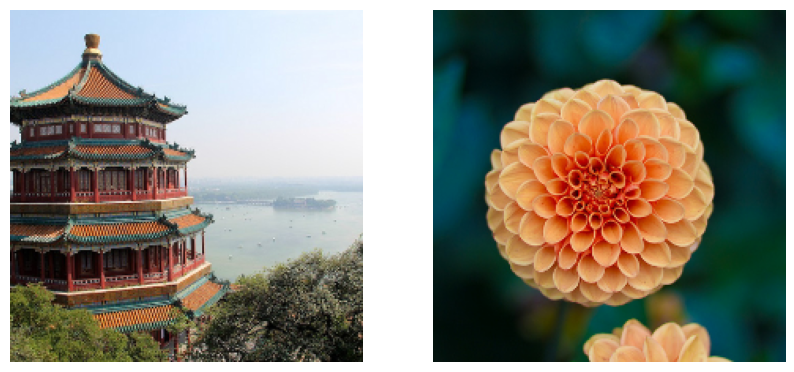

In [ ]:
plt.figure(figsize=(10, 6))
for idx in (0, 1):
  plt.subplot(1, 2, idx+1)
  plt.imshow(images_resized[idx] / 255)
  plt.axis('off')

plt.show()

In [ ]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)
dataset_size = info.splits["train"].num_examples
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes

In [ ]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

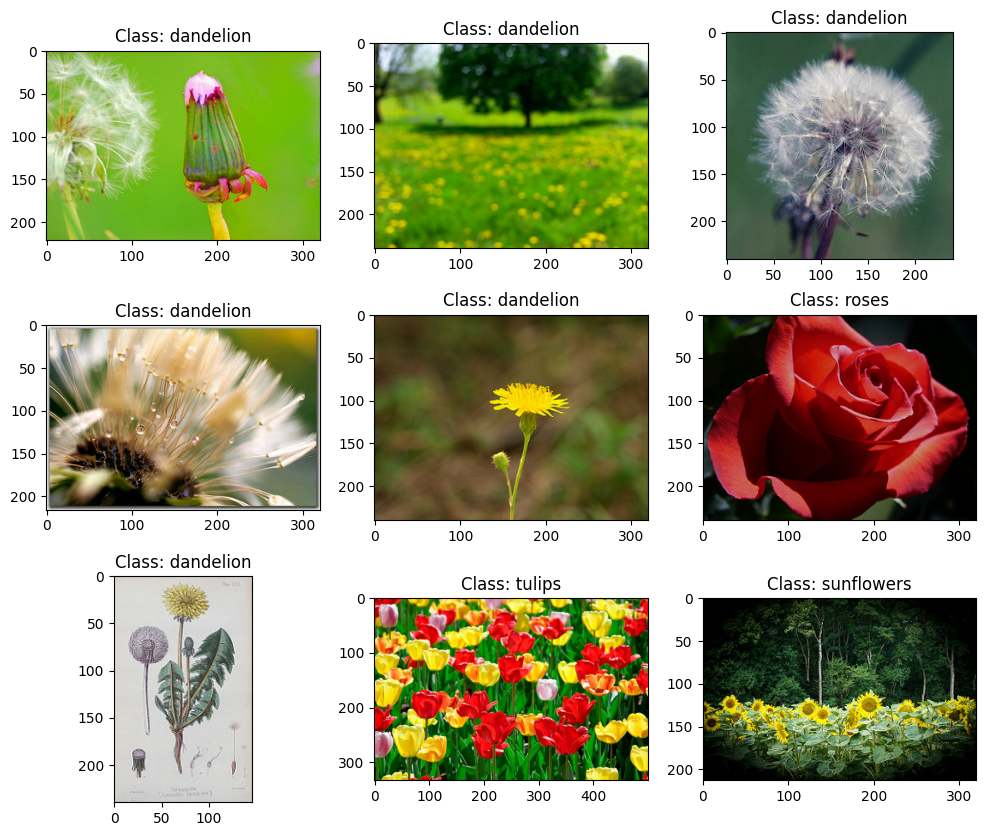

In [ ]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in valid_set_raw.take(9):
  index += 1
  plt.subplot(3, 3, index)
  plt.imshow(image)
  plt.title(f'Class: {class_names[label]}')

plt.show()

In [ ]:
tf.keras.backend.clear_session()

batch_size = 32
preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),
    tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input)
])
train_set = train_set_raw.map(lambda X, y: (preprocess(X), y))
train_set = train_set.shuffle(1000, seed=42).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)
test_set = test_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)

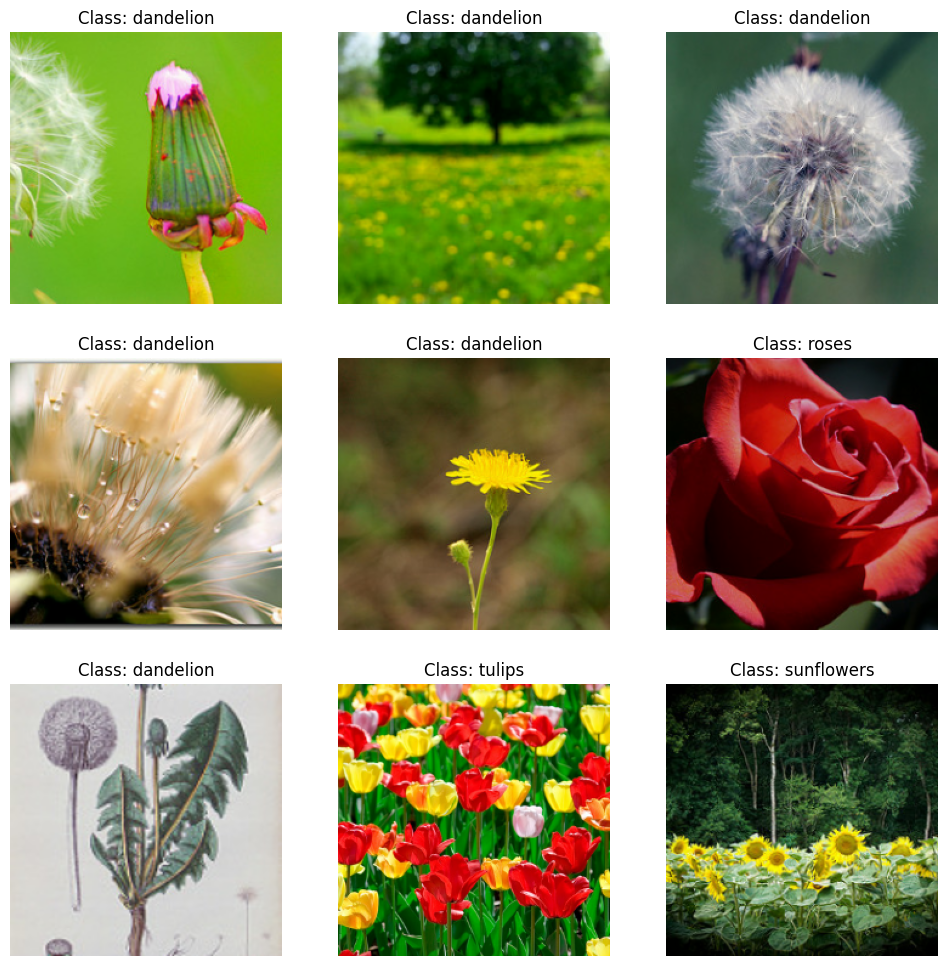

In [ ]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
  for index in range(9):
    plt.subplot(3, 3, index + 1)
    plt.imshow((X_batch[index] + 1) / 2)
    plt.title(f'Class: {class_names[y_batch[index]]}')
    plt.axis('off')

plt.show()

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode='horizontal', seed=42),
    tf.keras.layers.RandomRotation(factor=0.05, seed=42),
    tf.keras.layers.RandomContrast(factor=0.2, seed=42)
])

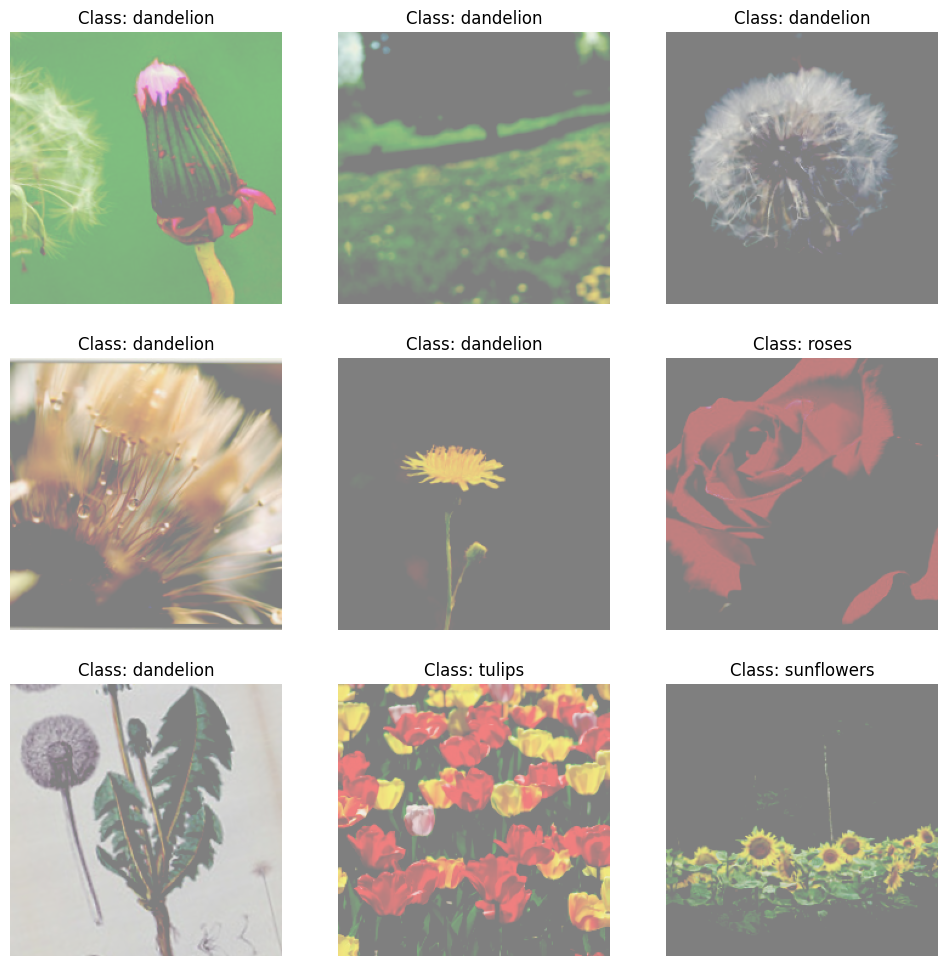

In [ ]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
  X_batch_augmented = data_augmentation(X_batch, training=True)
  for index in range(9):
    plt.subplot(3, 3, index+1)
    # We must rescale the images to the 0-1 range for imshow(), and also
    # clip the result to that range, because data augmentation may
    # make some values go out of bounds (e.g. RandomContrast in this case).
    plt.imshow(np.clip((X_batch_augmented[index] + 1) / 2, 0, 1))
    plt.title(f'Class: {class_names[y_batch[index]]}')
    plt.axis('off')

plt.show()

In [ ]:
tf.random.set_seed(42)
base_model = tf.keras.applications.xception.Xception(include_top=False,
                                                     weights='imagenet',)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(n_classes, activation='softmax')(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

In [ ]:
for layer in base_model.layers:
  layer.trainable = False

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer,
              metrics=['accuracy'])
history = model.fit(train_set, validation_data=valid_set, epochs=3)

Epoch 1/3
86/86 [==============================] - 20s 175ms/step - loss: 0.7541 - accuracy: 0.8045 - val_loss: 0.7181 - val_accuracy: 0.8330
Epoch 2/3
86/86 [==============================] - 15s 165ms/step - loss: 0.3186 - accuracy: 0.9092 - val_loss: 0.5952 - val_accuracy: 0.8439
Epoch 3/3
86/86 [==============================] - 15s 164ms/step - loss: 0.1782 - accuracy: 0.9390 - val_loss: 0.7305 - val_accuracy: 0.8621


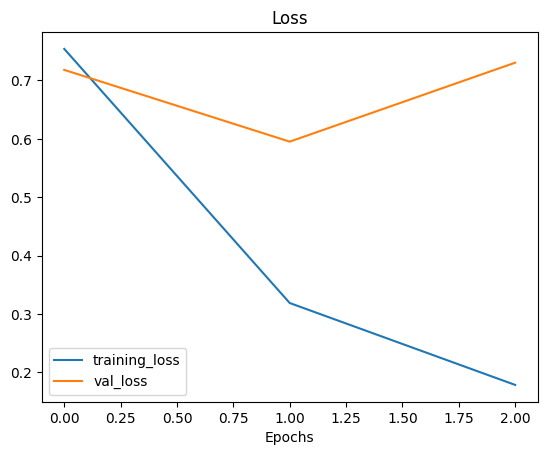

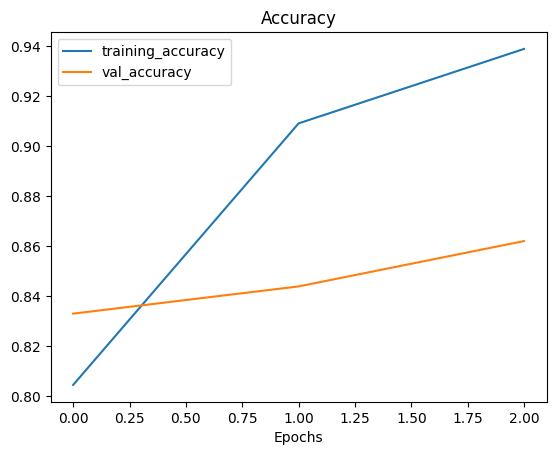

In [ ]:
plot_loss_curves(history)

In [ ]:
for indices in zip(range(33), range(33, 66), range(66, 99), range(99, 132)):
  for idx in indices:
    print(f'{idx:3}: {base_model.layers[idx].name:22}', end='')
  print()

  0: input_1                33: block4_pool            66: block8_sepconv1_act    99: block11_sepconv2_act  
  1: block1_conv1           34: batch_normalization_2  67: block8_sepconv1       100: block11_sepconv2      
  2: block1_conv1_bn        35: add_2                  68: block8_sepconv1_bn    101: block11_sepconv2_bn   
  3: block1_conv1_act       36: block5_sepconv1_act    69: block8_sepconv2_act   102: block11_sepconv3_act  
  4: block1_conv2           37: block5_sepconv1        70: block8_sepconv2       103: block11_sepconv3      
  5: block1_conv2_bn        38: block5_sepconv1_bn     71: block8_sepconv2_bn    104: block11_sepconv3_bn   
  6: block1_conv2_act       39: block5_sepconv2_act    72: block8_sepconv3_act   105: add_9                 
  7: block2_sepconv1        40: block5_sepconv2        73: block8_sepconv3       106: block12_sepconv1_act  
  8: block2_sepconv1_bn     41: block5_sepconv2_bn     74: block8_sepconv3_bn    107: block12_sepconv1      
  9: block2_sepconv

In [ ]:
for layer in base_model.layers[56:]:
  layer.trainable=True

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2, momentum=0.9)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer,
              metrics=['accuracy'])
history = model.fit(train_set, validation_data=valid_set, epochs=10)

Epoch 1/10
86/86 [==============================] - 35s 312ms/step - loss: 0.2923 - accuracy: 0.9110 - val_loss: 0.4534 - val_accuracy: 0.8820
Epoch 2/10
86/86 [==============================] - 27s 303ms/step - loss: 0.0388 - accuracy: 0.9884 - val_loss: 0.3508 - val_accuracy: 0.8947
Epoch 3/10
86/86 [==============================] - 27s 305ms/step - loss: 0.0154 - accuracy: 0.9967 - val_loss: 0.3643 - val_accuracy: 0.9074
Epoch 4/10
86/86 [==============================] - 27s 300ms/step - loss: 0.0125 - accuracy: 0.9964 - val_loss: 0.3473 - val_accuracy: 0.9111
Epoch 5/10
86/86 [==============================] - 26s 301ms/step - loss: 0.0096 - accuracy: 0.9967 - val_loss: 0.3739 - val_accuracy: 0.9038
Epoch 6/10
86/86 [==============================] - 26s 295ms/step - loss: 0.0034 - accuracy: 0.9993 - val_loss: 0.3758 - val_accuracy: 0.9056
Epoch 7/10
86/86 [==============================] - 26s 299ms/step - loss: 0.0027 - accuracy: 0.9996 - val_loss: 0.3706 - val_accuracy: 0.9111

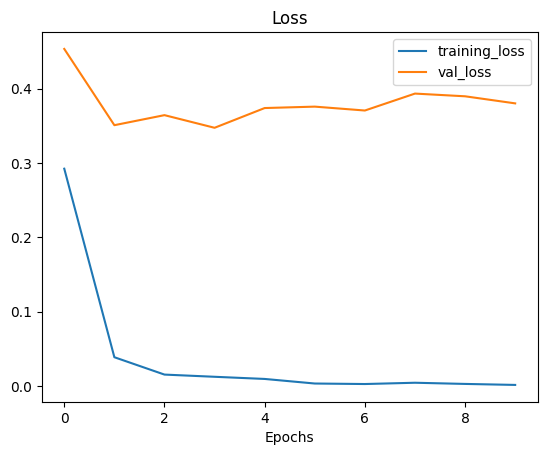

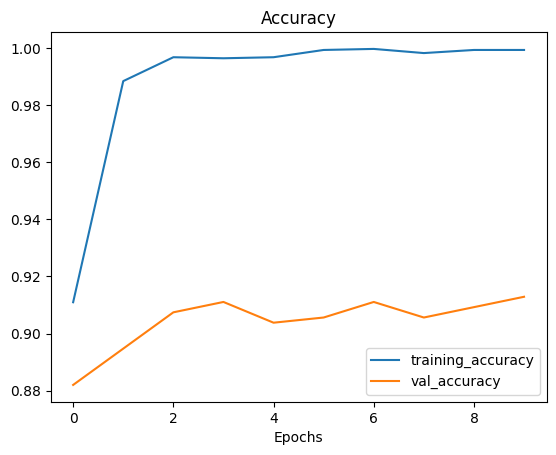

In [ ]:
plot_loss_curves(history)

In [ ]:
#tf.keras.layers.SeperableConv2D

In [ ]:
#print('a', 'b', sep='|')

# Classification and Localization

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
tf.random.set_seed(42)

base_model = tf.keras.applications.xception.Xception(weights='imagenet',
                                                     include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = tf.keras.layers.Dense(n_classes, activation = 'softmax')(avg)
loc_output = tf.keras.layers.Dense(4)(avg)
model=tf.keras.Model(inputs = base_model.input,
                     outputs = [class_output, loc_output])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2, momentum=0.9)
model.compile(loss = ['sparse_categorical_crossentropy', 'mse'],
              optimizer=optimizer,
              metrics='accuracy')

In [ ]:
def add_random_bounding_boxes(images, labels):
  fake_bboxes = tf.random.uniform([tf.shape(images)[0], 4])
  return images, (labels, fake_bboxes)

fake_train_set = train_set.take(5).repeat(2).map(add_random_bounding_boxes)
model.fit(fake_train_set, epochs=2)

Epoch 1/2
10/10 [==============================] - 18s 481ms/step - loss: 1.6611 - dense_loss: 1.4599 - dense_1_loss: 0.2012 - dense_accuracy: 0.4219 - dense_1_accuracy: 0.3063
Epoch 2/2
10/10 [==============================] - 5s 485ms/step - loss: 1.0578 - dense_loss: 0.9050 - dense_1_loss: 0.1528 - dense_accuracy: 0.7469 - dense_1_accuracy: 0.2313
